In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.metrics import PredictionErrorDisplay, median_absolute_error
from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

In [2]:
#p_karst_with_controls = gpd.read_file('p_karst_controls_and_slope_5070.shp')
#p_karst_with_controls = gpd.read_file("p_karst_with_controls_5070.shp")
p_karst_with_controls = gpd.read_file('temp_p_karst_with_controls_5070.shp')
p_karst_with_controls.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 29068 entries, 0 to 29067
Data columns (total 42 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   objectid    29068 non-null  float64 
 1   tnmid       29068 non-null  object  
 2   metasource  11319 non-null  object  
 3   sourcedata  655 non-null    object  
 4   sourceorig  675 non-null    object  
 5   sourcefeat  0 non-null      object  
 6   loaddate    29011 non-null  object  
 7   referenceg  174 non-null    object  
 8   areaacres   29068 non-null  float64 
 9   areasqkm    29068 non-null  float64 
 10  states      29068 non-null  object  
 11  huc12       29068 non-null  object  
 12  name        29068 non-null  object  
 13  hutype      29068 non-null  object  
 14  humod       29060 non-null  object  
 15  tohuc       29068 non-null  object  
 16  noncontrib  27978 non-null  float64 
 17  noncontr_1  27898 non-null  float64 
 18  globalid    29068 non-null  object  
 

In [ ]:
XY = p_karst_with_controls.loc[:, ['mean annua', 'annual pre', 
       'precipitat', 
       'clay', 'sand', 'silt', 
       'exposure_i', 'huc_carb_i', 'median_slo',  'p_karst']].copy()
XY.dropna(inplace=True)

X = XY.loc[:,['mean annua', 'annual pre', 
       'precipitat', 
       'clay', 'sand', 'silt', 
       'exposure_i', 'huc_carb_i', 'median_slo', ]]

Y = XY.p_karst
X.info()
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

In [4]:
p_karst_with_controls_nonzero = p_karst_with_controls[p_karst_with_controls.p_karst>0]
p_karst_with_controls_nonzero.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 5511 entries, 11 to 29050
Data columns (total 42 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   objectid    5511 non-null   float64 
 1   tnmid       5511 non-null   object  
 2   metasource  2151 non-null   object  
 3   sourcedata  119 non-null    object  
 4   sourceorig  118 non-null    object  
 5   sourcefeat  0 non-null      object  
 6   loaddate    5511 non-null   object  
 7   referenceg  8 non-null      object  
 8   areaacres   5511 non-null   float64 
 9   areasqkm    5511 non-null   float64 
 10  states      5511 non-null   object  
 11  huc12       5511 non-null   object  
 12  name        5511 non-null   object  
 13  hutype      5511 non-null   object  
 14  humod       5510 non-null   object  
 15  tohuc       5511 non-null   object  
 16  noncontrib  5153 non-null   float64 
 17  noncontr_1  5149 non-null   float64 
 18  globalid    5511 non-null   object  
 19  s

In [5]:
p_karst_with_controls_nonzero.keys()

Index(['objectid', 'tnmid', 'metasource', 'sourcedata', 'sourceorig',
       'sourcefeat', 'loaddate', 'referenceg', 'areaacres', 'areasqkm',
       'states', 'huc12', 'name', 'hutype', 'humod', 'tohuc', 'noncontrib',
       'noncontr_1', 'globalid', 'shape_Leng', 'shape_Area', 'p_karst',
       'mean annua', 'annual pre', 'precipitat', 'net primar', 'cmi mean',
       'carbonate', 'clay', 'organic ma', 'ph', 'sand', 'silt', 'dominant_r',
       'exposure_i', 'huc_carb_i', 'huc_pct_ar', 'median_slo', 'max_elev',
       'min_elev', 'f_steep', 'geometry'],
      dtype='object')

In [6]:
#common_rocks = ['limestone', 'dolostone (dolomite)', 'shale', 'sandstone']
#p_karst_with_controls_nonzero = p_karst_with_controls_nonzero[p_karst_with_controls_nonzero.rocktype1.isin(common_rocks)]
#p_karst_with_controls_nonzero.info()


In [8]:
p_karst_with_controls_nonzero.dominant_r.unique()


array(['None', 'dolostone (dolomite)', 'shale', 'limestone', 'sand',
       'sandstone', 'mixed clastic/carbonate', 'carbonate', 'chert',
       'fine-grained mixed clastic', 'meta-argillite', 'clay or mud',
       None, 'mudstone', 'calcarenite', 'schist', 'metasedimentary rock',
       'marble', 'argillite', 'medium-grained mixed clastic', 'clastic',
       'residuum', 'dolostone', 'mylonite', 'slate', 'calcareous sand',
       'siltstone', 'biotite gneiss', 'hornfels', 'sedimentary rock',
       'graywacke', 'orthoquartzite', 'claystone', 'terrace'],
      dtype=object)

Select factors and prediction variable and create categories

In [73]:
"""XY = p_karst_with_controls_nonzero.loc[:,['exposure', 'induration', 'rocktype1',
       'mean annua', 'mean diurn',
       'isothermal', 'annual pre',
       'precipitat', 'net primar',
       'monthly me', 'cmi mean', 'carbonate', 'clay', 'density', 'ksat',
       'organic ma', 'ph', 'depth res', 'rock fragm', 'sand', 'silt',
       'depth', 'water stor', 'p_karst', 'median_slo']].copy()
"""

"""
XY = p_karst_with_controls_nonzero.loc[:, ['mean annua', 'annual pre', 
       'precipitat', 'net primar', 'cmi mean',
       'carbonate', 'clay', 'organic ma', 'ph', 'sand', 'silt', 
       'exposure_i', 'huc_carb_i', 'median_slo', 'f_steep', 'p_karst']].copy()
XY.dropna(inplace=True)

X = XY.loc[:,['mean annua', 'annual pre', 
       'precipitat', 'net primar', 'cmi mean',
       'carbonate', 'clay', 'organic ma', 'ph', 'sand', 'silt', 
       'exposure_i', 'huc_carb_i', 'median_slo', 'f_steep']]
"""
XY = p_karst_with_controls_nonzero.loc[:, ['mean annua', 'annual pre', 
       'precipitat', 
       'clay', 'sand', 'silt', 
       'exposure_i', 'huc_carb_i', 'median_slo',  'p_karst']].copy()
XY.dropna(inplace=True)

X = XY.loc[:,['mean annua', 'annual pre', 
       'precipitat', 
       'clay', 'sand', 'silt', 
       'exposure_i', 'huc_carb_i', 'median_slo', ]]

Y = XY.p_karst
#X['rocktype1'] = X['rocktype1'].astype('category')
#X['exposure'] = X['exposure'].astype('category')
#X['induration'] = X['induration'].astype('category')

#log transform slope
#X['log_slope'] = np.log10(X['median_slo'])
X.info()
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

<class 'pandas.core.frame.DataFrame'>
Index: 5510 entries, 11 to 29050
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   mean annua  5510 non-null   float64
 1   annual pre  5510 non-null   float64
 2   precipitat  5510 non-null   float64
 3   clay        5510 non-null   float64
 4   sand        5510 non-null   float64
 5   silt        5510 non-null   float64
 6   exposure_i  5510 non-null   float64
 7   huc_carb_i  5510 non-null   float64
 8   median_slo  5510 non-null   float64
dtypes: float64(9)
memory usage: 430.5 KB


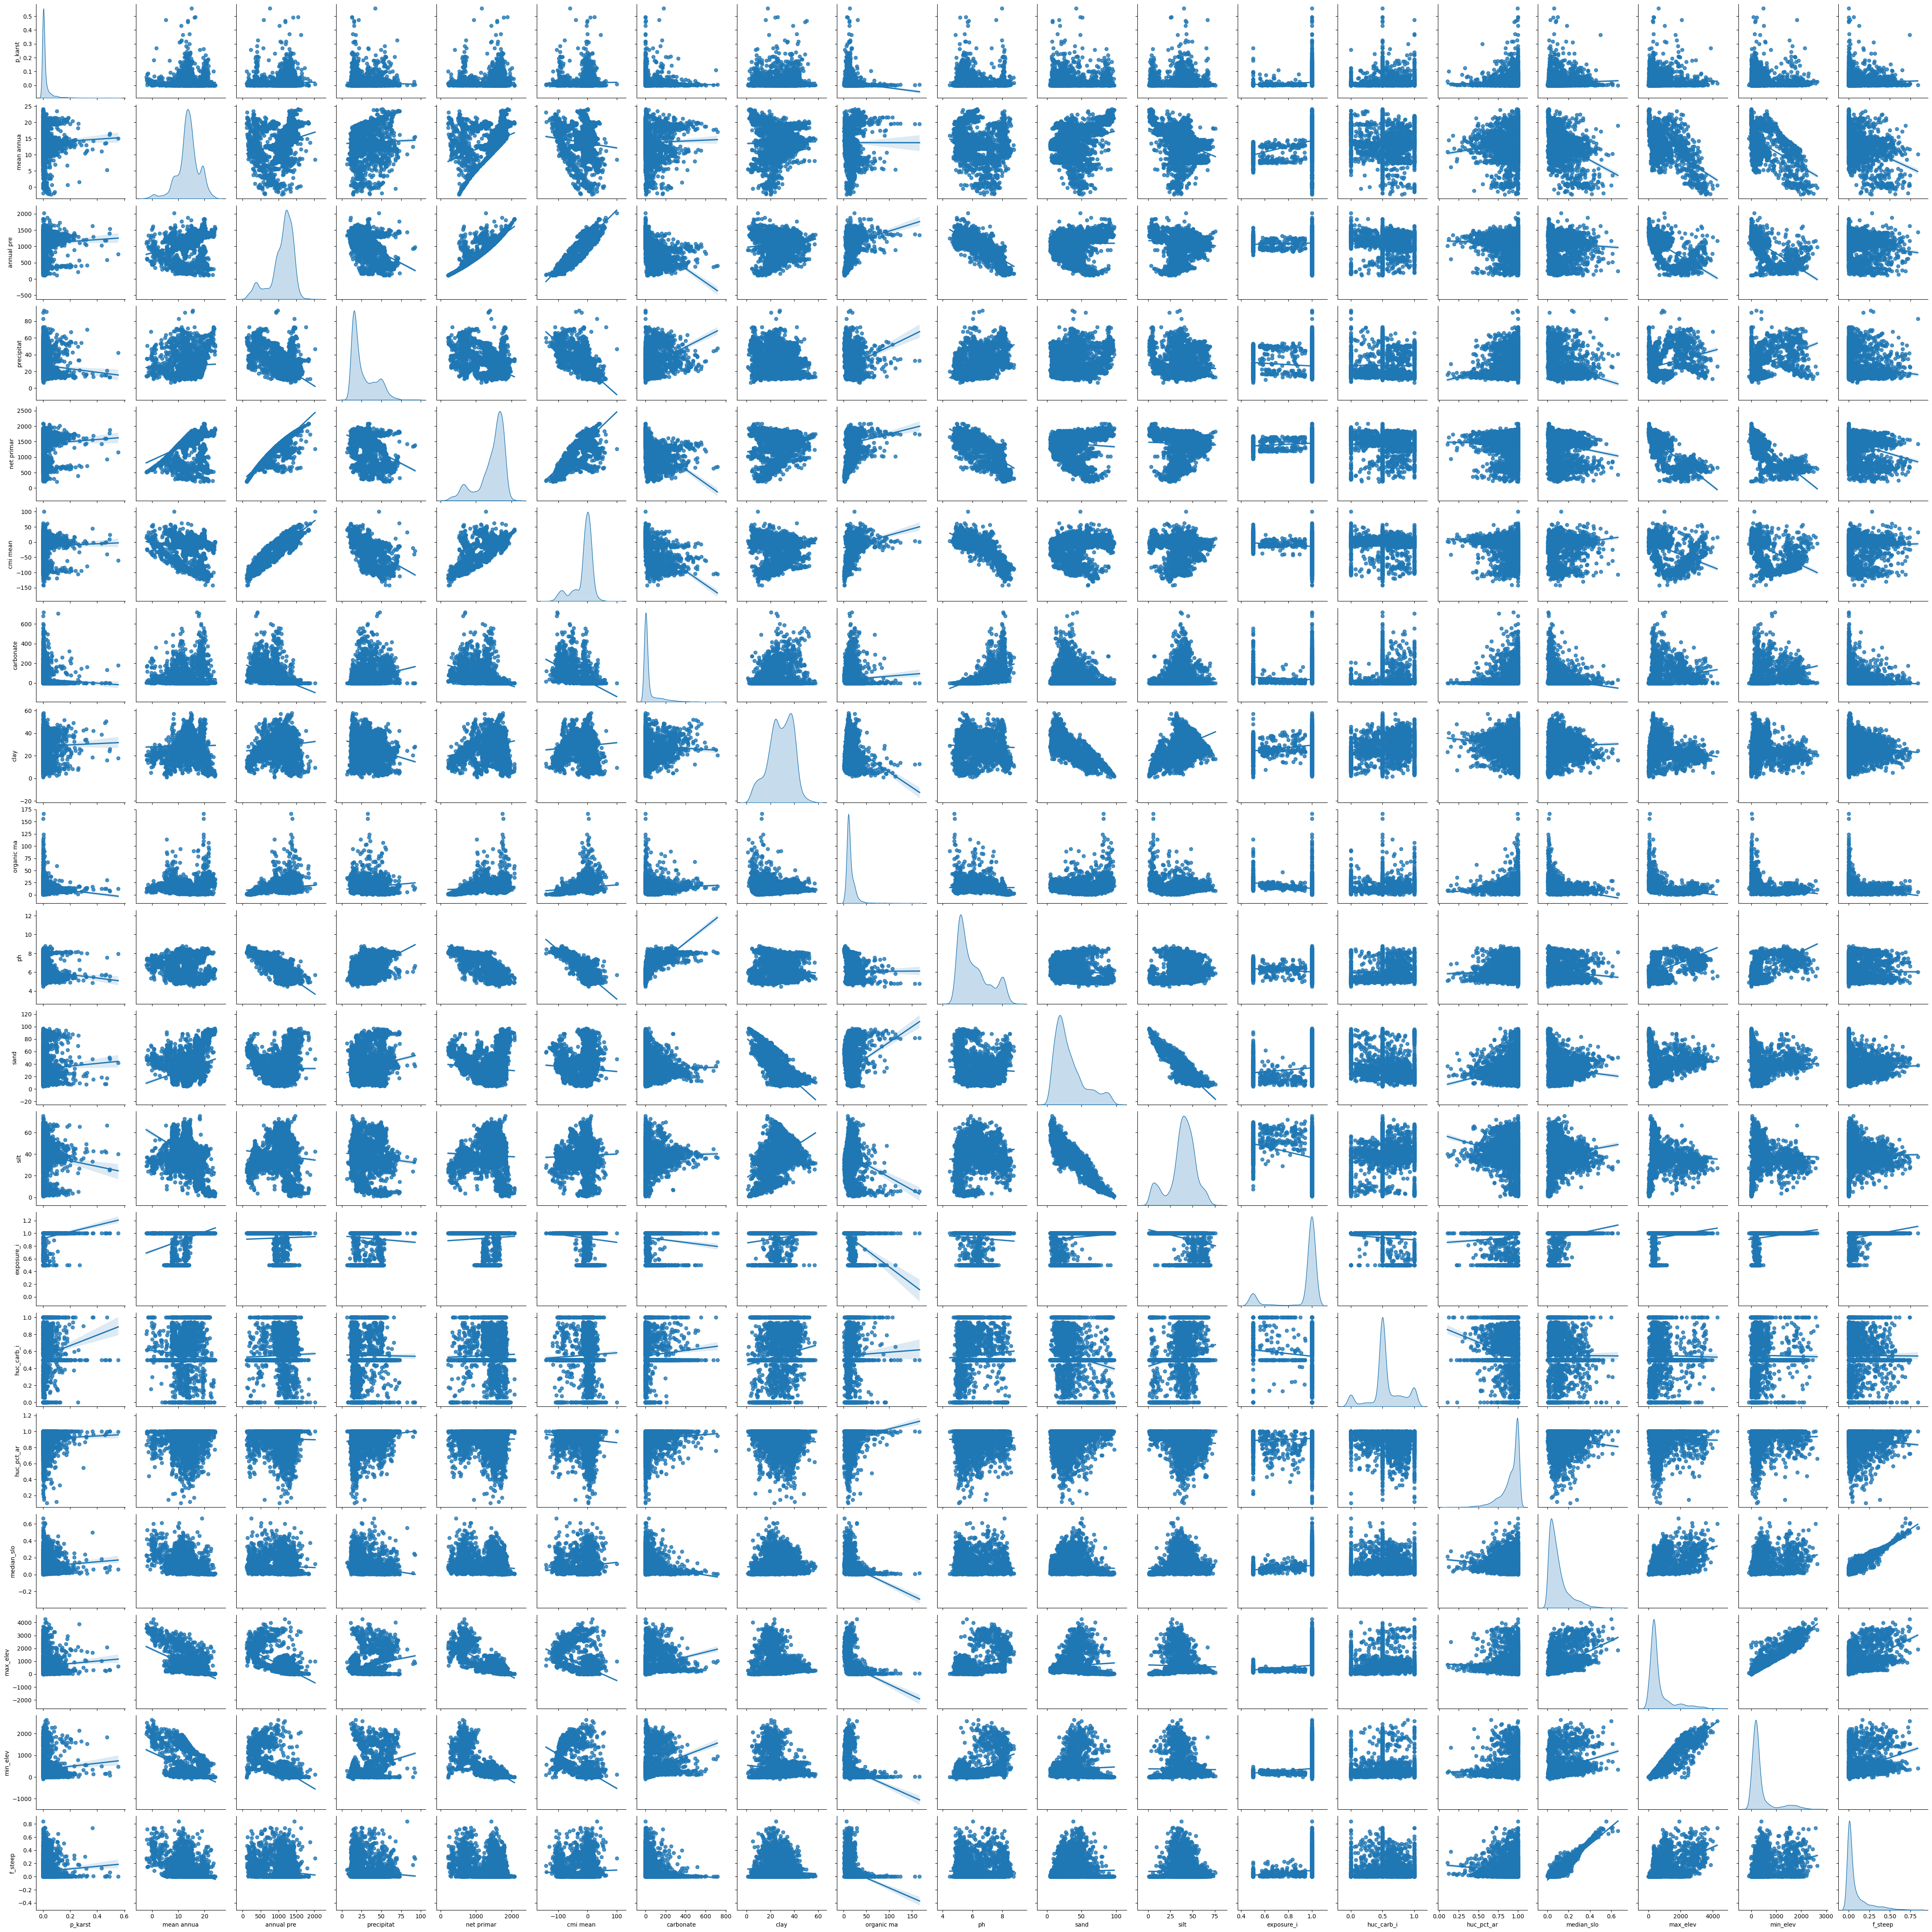

In [13]:
train_dataset = X_train.copy()
train_dataset.insert(0,"p_karst", y_train)
_ = sns.pairplot(train_dataset, kind="reg", diag_kind="kde")

In [74]:
#categorical_columns = ["exposure", "rocktype1", "induration"]
#categorical_columns = ["exposure", "rocktype1", ]
categorical_columns = []

"""
numerical_columns = ['mean annua', 'mean diurn',
       'isothermal', 'annual pre', 'precipitat', 'net primar', 'monthly me',
       'cmi mean', 'carbonate', 'clay', 'density', 'ksat', 'organic ma', 'ph',
       'depth res', 'rock fragm', 'sand', 'silt', 'depth', 'water stor']
"""

#numerical_columns = ['mean annua', 'annual pre', 'precipitat',  
#              'silt', 'clay', 'huc_carb_i']
numerical_columns = ['mean annua', 'annual pre', 
       'precipitat', 
       'clay', 'sand', 'silt', 
       'exposure_i', 'huc_carb_i', 'median_slo']

preprocessor = make_column_transformer(
    (OneHotEncoder(drop="if_binary"), categorical_columns),
    (StandardScaler(), numerical_columns),
    verbose_feature_names_out=False,  # avoid to prepend the preprocessor names
)
alphas = np.logspace(-10, 10, 21)  # alpha values to be chosen from by cross-validation

model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=RidgeCV(alphas=alphas), func=np.log10, inverse_func=sp.special.exp10
    ),
)

model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  []),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['mean annua', 'annual pre',
                                                   'precipitat', 'clay', 'sand',
                                                   'silt', 'exposure_i',
                                                   'huc_carb_i',
                                                   'median_slo'])],
                                   verbose_feature_names_out=False)),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log10'>,
                                            inverse_func=<ufunc 'exp10'>,
                                            regressor=RidgeCV(alphas=array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10]))))])

In [75]:
model[-1].regressor_.alpha_

1.0

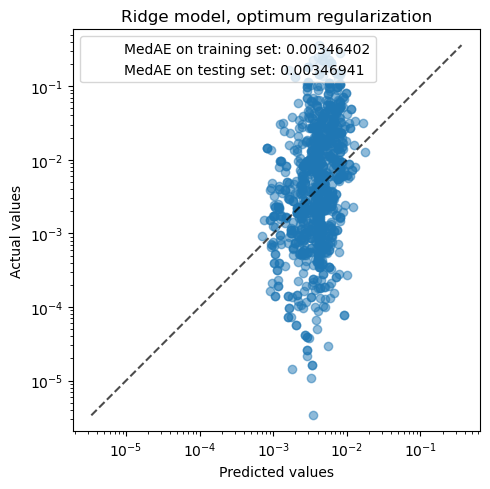

In [76]:
mae_train = median_absolute_error(y_train, model.predict(X_train))
y_pred = model.predict(X_test)
mae_test = median_absolute_error(y_test, y_pred)
scores = {
    "MedAE on training set": f"{mae_train:.8f}",
    "MedAE on testing set": f"{mae_test:.8f} ",
}

_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5},
)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title("Ridge model, optimum regularization")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()

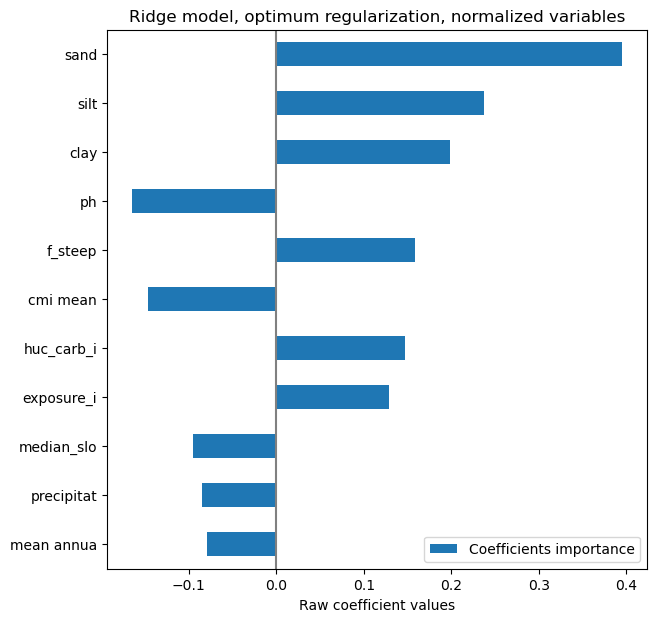

In [18]:
feature_names = model[:-1].get_feature_names_out()

coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=["Coefficients importance"],
    index=feature_names,
)
coefs.sort_values(by='Coefficients importance', key=np.abs, inplace=True)
coefs.plot.barh(figsize=(9, 7))
plt.title("Ridge model, optimum regularization, normalized variables")
plt.xlabel("Raw coefficient values")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

In [19]:
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=0)

cv_model = cross_validate(
    model,
    X,
    Y,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)
coefs = pd.DataFrame(
    [est[-1].regressor_.coef_ for est in cv_model["estimator"]], columns=feature_names
)

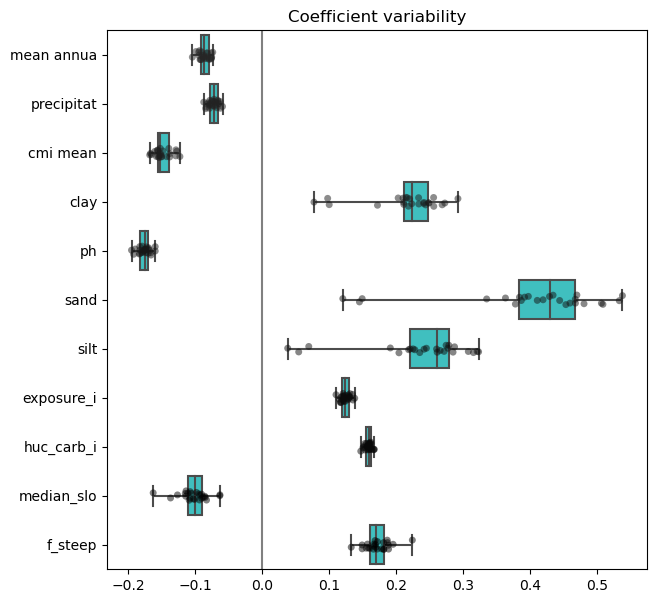

In [20]:
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
plt.title("Coefficient variability")
plt.subplots_adjust(left=0.3)

In [21]:
alphas = np.logspace(-10, 10, 21)  # alpha values to be chosen from by cross-validation
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=LassoCV(alphas=alphas, max_iter=100_000),
        func=np.log10,
        inverse_func=sp.special.exp10,
    ),
)

_ = model.fit(X_train, y_train)

In [22]:
model[-1].regressor_.alpha_

1e-05

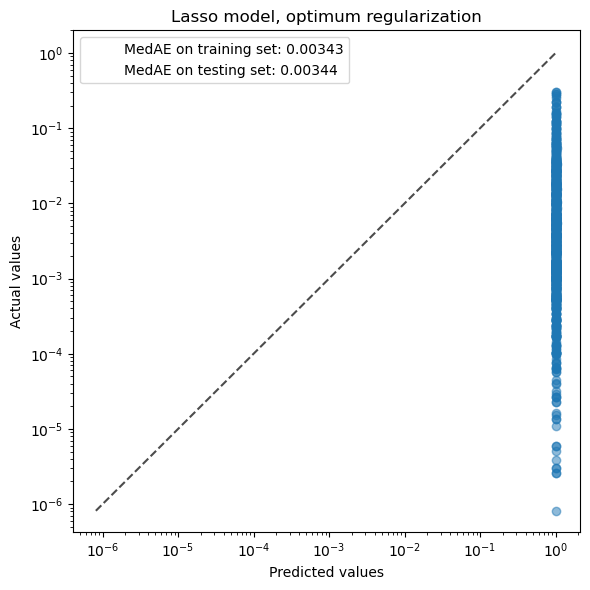

In [23]:
mae_train = median_absolute_error(y_train, model.predict(X_train))
y_pred = model.predict(X_test)
mae_test = median_absolute_error(y_test, y_pred)
scores = {
    "MedAE on training set": f"{mae_train:.5f}",
    "MedAE on testing set": f"{mae_test:.5f}",
}

_, ax = plt.subplots(figsize=(6, 6))
display = PredictionErrorDisplay.from_predictions(
    y_test, 10**y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("Lasso model, optimum regularization")
ax.set_xscale('log')
ax.set_yscale('log')
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()

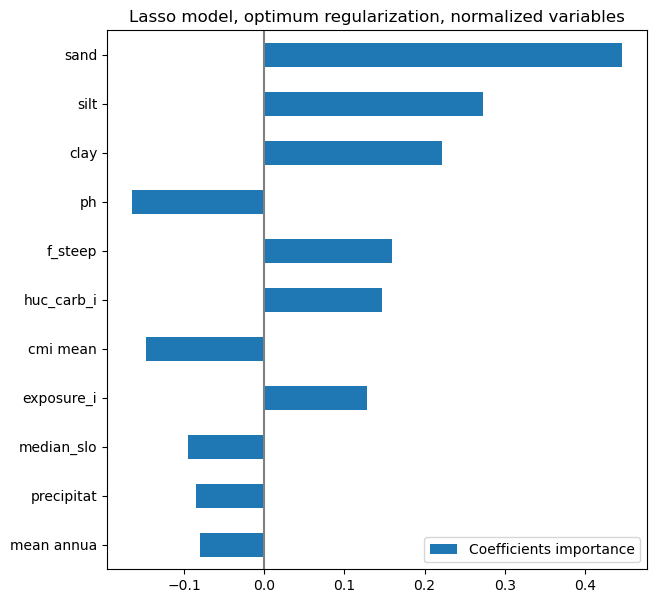

In [24]:
coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=["Coefficients importance"],
    index=feature_names,
)
coefs.sort_values(by='Coefficients importance', key=np.abs, inplace=True)
coefs.plot(kind="barh", figsize=(9, 7))
plt.title("Lasso model, optimum regularization, normalized variables")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

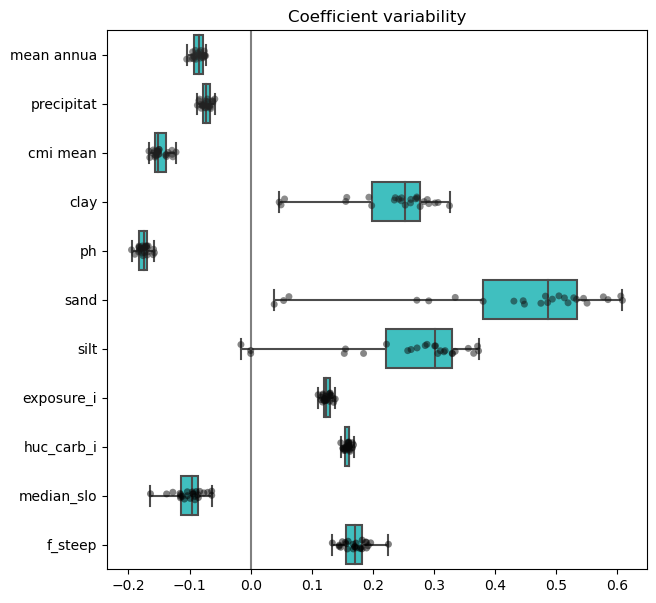

In [25]:
cv_model = cross_validate(
    model,
    X,
    Y,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)
coefs = pd.DataFrame(
    [est[-1].regressor_.coef_ for est in cv_model["estimator"]], columns=feature_names
)
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=100)
plt.axvline(x=0, color=".5")
plt.title("Coefficient variability")
plt.subplots_adjust(left=0.3)

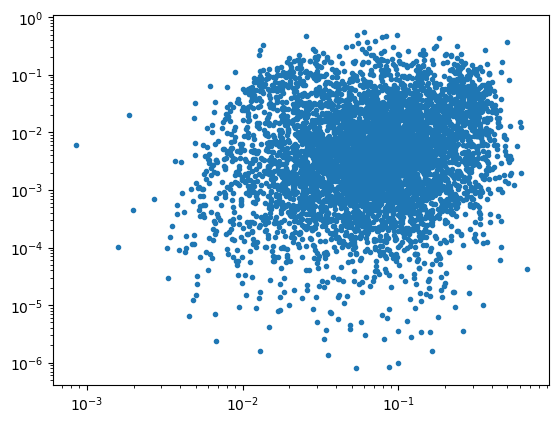

In [26]:
plt.loglog(X['median_slo'], Y, '.')

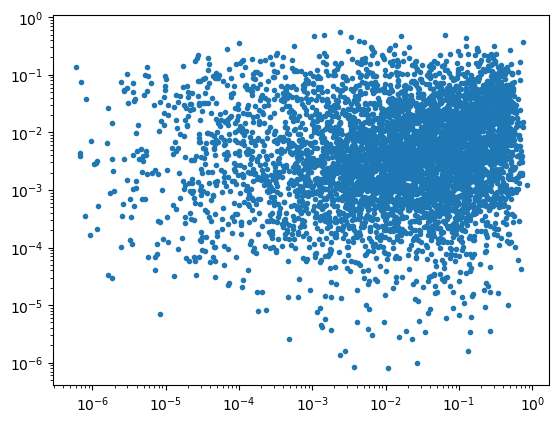

In [27]:
plt.loglog(X['f_steep'], Y, '.')

Text(0, 0.5, 'Silt')

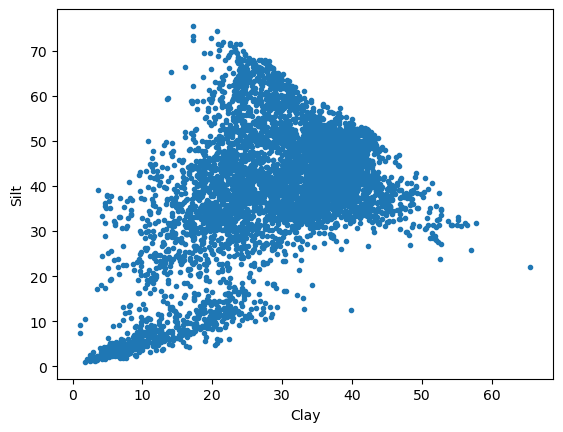

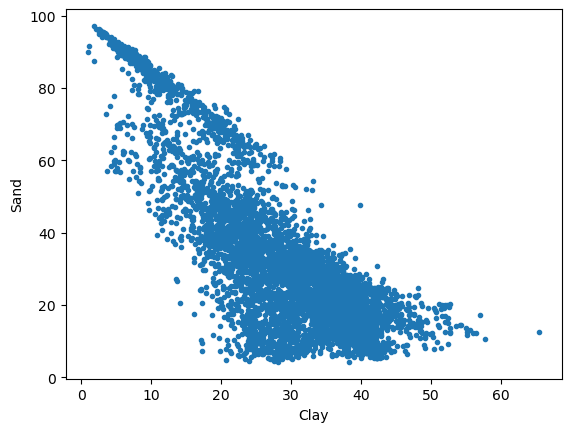

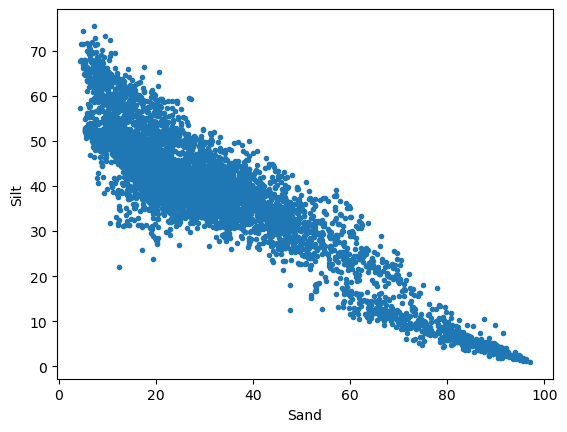

In [34]:
plt.plot(X.clay, X.silt, '.')
plt.xlabel('Clay')
plt.ylabel('Silt')
plt.figure()
plt.plot(X.clay, X.sand, '.')
plt.xlabel('Clay')
plt.ylabel('Sand')
plt.figure()
plt.plot(X.sand, X.silt, '.')
plt.xlabel('Sand')
plt.ylabel('Silt')

Text(-1.9518696424696156, 0.5, 'p_karst')

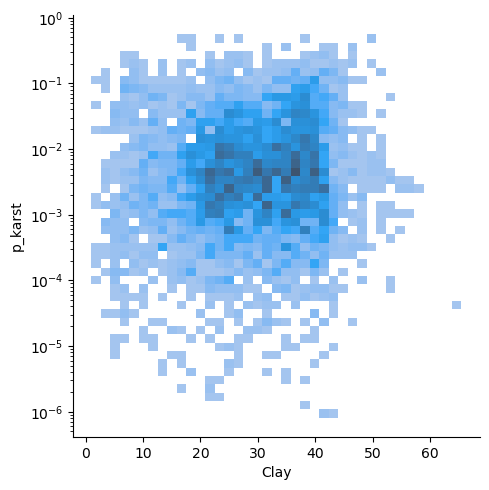

<Figure size 640x480 with 0 Axes>

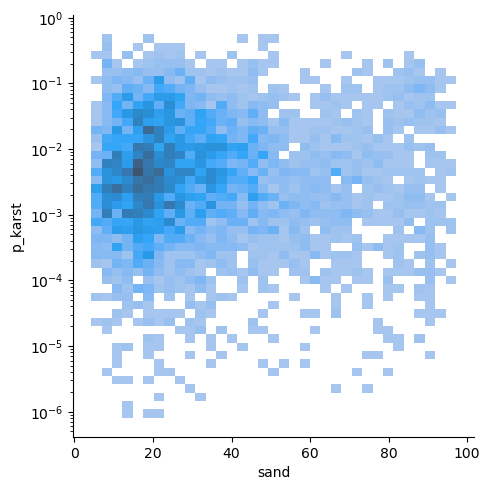

<Figure size 640x480 with 0 Axes>

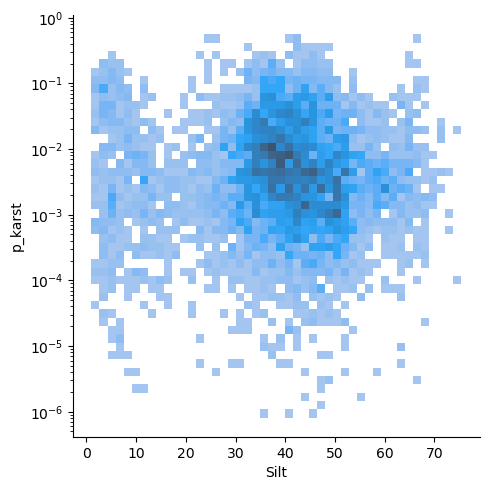

In [43]:
import seaborn as sns
#plt.semilogy(X.clay, Y, '.')
sns.displot(x=X.clay, y=Y, log_scale=(False, True))
plt.xlabel('Clay')
plt.ylabel('p_karst')
plt.figure()
sns.displot(x=X.sand, y=Y, log_scale=(False, True))
#plt.semilogy(X.sand, Y, '.')
plt.xlabel('sand')
plt.ylabel('p_karst')
plt.figure()
#plt.semilogy(X.silt, Y, '.')
sns.displot(x=X.silt, y=Y, log_scale=(False, True))

plt.xlabel('Silt')
plt.ylabel('p_karst')

Text(0, 0.5, 'p_karst')

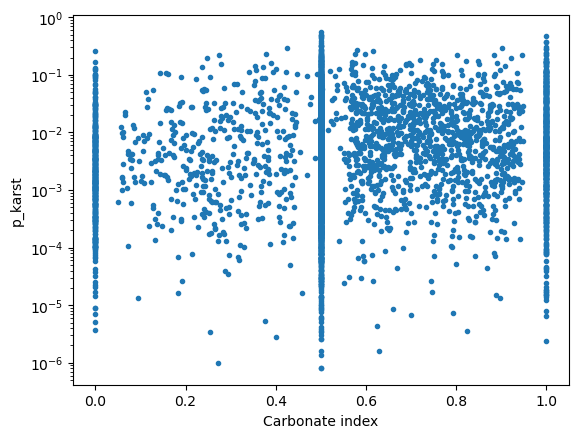

In [28]:
plt.semilogy(X.huc_carb_i, Y, '.')
plt.xlabel('Carbonate index')
plt.ylabel('p_karst')

Text(0, 0.5, 'p_karst')

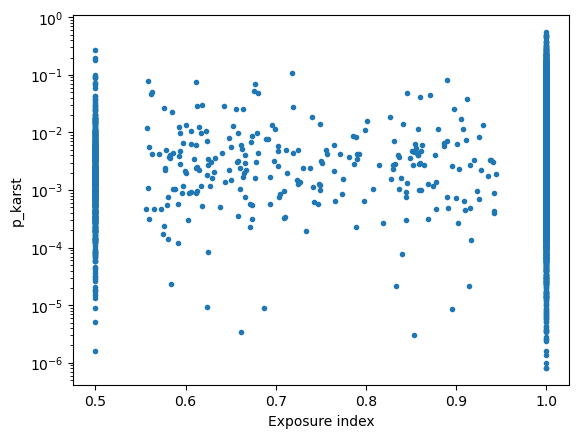

In [30]:
plt.semilogy(X.exposure_i, Y, '.')
plt.xlabel('Exposure index')
plt.ylabel('p_karst')

In [25]:
frac_error = model.predict(X)/Y
frac_error

11        0.617633
12        0.502567
13        3.307725
15       38.740883
27        0.992030
           ...    
29045     0.020609
29047     0.131598
29048     0.027251
29049     1.169183
29050     0.053653
Name: p_karst, Length: 5351, dtype: float64

(array([  48.,  373.,  986., 1589., 1342.,  663.,  235.,   69.,   35.,
          11.]),
 array([-2.36126466, -1.75641205, -1.15155944, -0.54670682,  0.05814579,
         0.6629984 ,  1.26785101,  1.87270362,  2.47755623,  3.08240884,
         3.68726145]),
 <BarContainer object of 10 artists>)

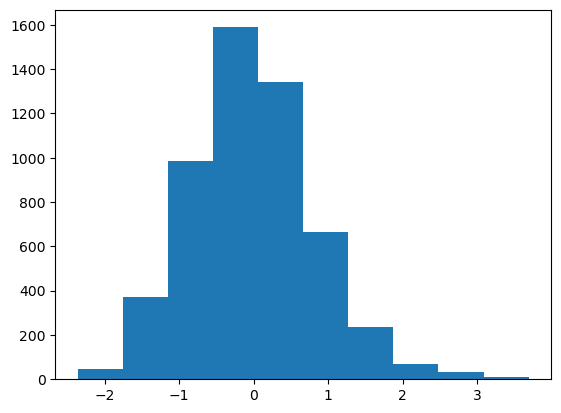

In [19]:
plt.hist(np.log10(frac_error))

In [28]:
error_locations = pd.concat([frac_error, p_karst_with_controls_nonzero.geometry], axis=1)

In [31]:
error_locations = gpd.GeoDataFrame(error_locations)

In [33]:
error_locations.dropna(inplace=True)
error_locations

p_karst                                           geometry
11      0.617633  POLYGON ((308298.974 2383929.132, 308461.797 2...
12      0.502567  POLYGON ((285203.331 2338570.667, 285286.271 2...
13      3.307725  POLYGON ((267777.249 2361445.385, 267850.320 2...
15     38.740883  POLYGON ((285395.822 2379237.606, 285590.214 2...
27      0.992030  POLYGON ((389617.827 2325854.704, 389618.883 2...
...          ...                                                ...
29045   0.020609  MULTIPOLYGON (((1322485.957 721578.270, 132255...
29047   0.131598  POLYGON ((1318955.783 827929.845, 1318849.016 ...
29048   0.027251  POLYGON ((1343343.918 801905.651, 1343359.847 ...
29049   1.169183  POLYGON ((1343084.741 811291.328, 1343068.471 ...
29050   0.053653  MULTIPOLYGON (((1352259.863 803885.263, 135229...

[5351 rows x 2 columns]

In [35]:
error_locations.to_file('error_locations.shp')

In [36]:
!pip install git+https://github.com/lanl/pyBASS.git

  Cloning https://github.com/lanl/pyBASS.git to /tmp/pip-req-build-q9fc3fy6
  Running command git clone --filter=blob:none --quiet https://github.com/lanl/pyBASS.git /tmp/pip-req-build-q9fc3fy6
  Resolved https://github.com/lanl/pyBASS.git to commit d8ecc174288239951fde394ac83ffdc6f701c8b2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyBASS: filename=pyBASS-0.3.2-py3-none-any.whl size=21121 sha256=e158213a1127a75a3821f841d46244c49c4dfd11ab902af2f697ba90f8df24eb
  Stored in directory: /tmp/pip-ephem-wheel-cache-l6vqd2i1/wheels/81/0e/e6/5317ee128b9f5e4f3afc51e5e9f51d3c9df6dc261795e9ea9c
Successfully built pyBASS


In [37]:
import pyBASS as pb

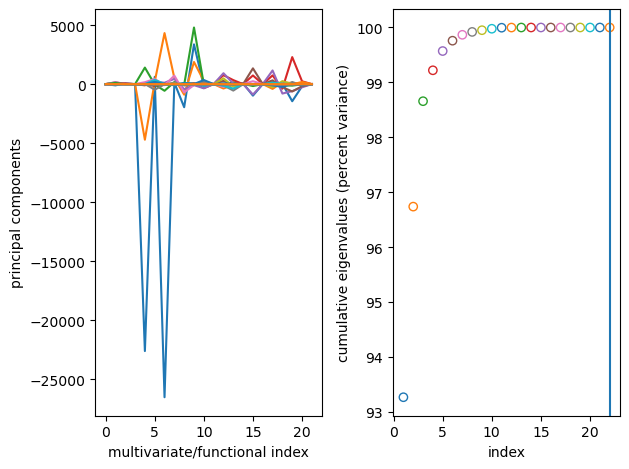

In [39]:
pca = pb.BassPCAsetup(XY)
pca.plot()

In [51]:
mod = pb.bass(X.values,Y.values)

BASS MCMC Complete. Time: 4.006294 seconds.


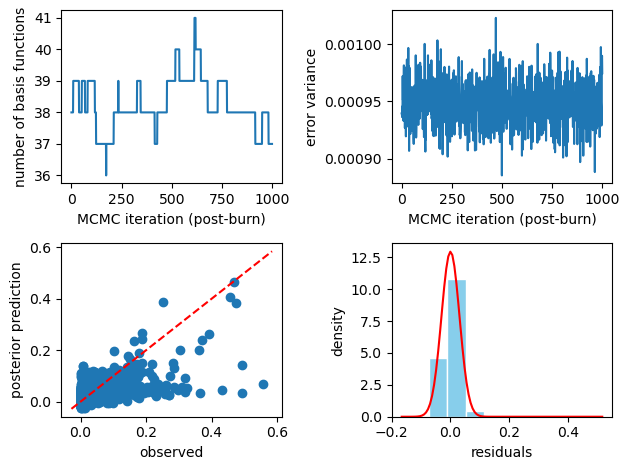

In [52]:
mod.plot()

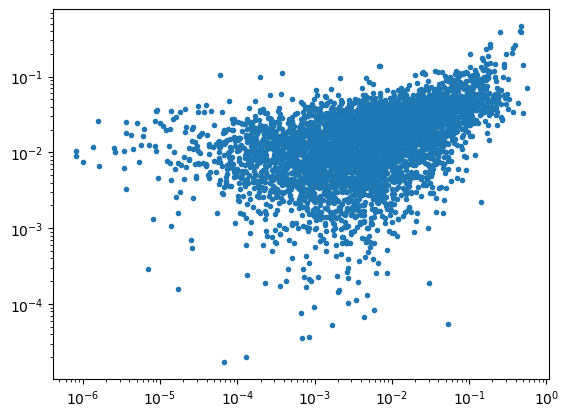

In [60]:
p_pred = mod.predict(X.values)
plt.loglog(Y, p_pred.mean(axis=0), '.')
plt.show()

In [77]:
bm = mod.makeBasisMatrix(5, X.values)

In [75]:
pb.BassBasis(X.values,Y.values,bm, )

TypeError: BassBasis.__init__() missing 5 required positional arguments: 'basis', 'newy', 'y_mean', 'y_sd', and 'trunc_error'

In [81]:
sb = pb.sobolBasis(mod)

In [85]:
sb.plot()

AttributeError: 'sobolBasis' object has no attribute 'xx'

In [88]:
mod

PCA analysis

In [89]:
from sklearn.decomposition import PCA

In [107]:
pca = PCA(3)

In [108]:
X_reduced = pca.fit_transform(X)

In [111]:
%matplotlib

Using matplotlib backend: QtAgg


In [112]:
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)


ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    X_reduced[:, 2],
    c=np.log10(Y),
)

Decision tree

In [77]:
from sklearn import tree

clf = tree.DecisionTreeRegressor(min_samples_leaf=10)

In [78]:
clf = clf.fit(X_train, np.log10(y_train))

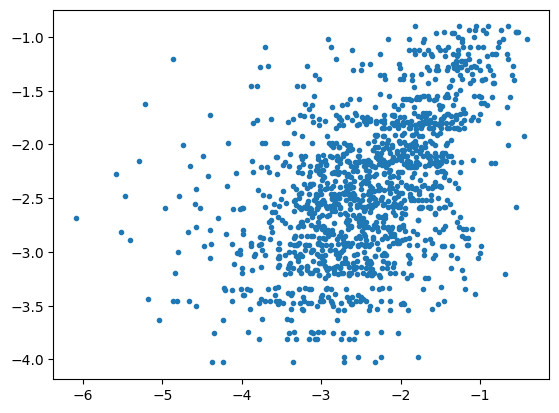

In [79]:
plt.plot(np.log10(y_test), clf.predict(X_test), '.')

In [80]:
clf.score(X_test, y_test)

-4533.329075112517

In [81]:
for i, feat in enumerate(clf.feature_importances_):
    print(clf.feature_names_in_[i], feat)

mean annua 0.19488717204059613
annual pre 0.07876071586447007
precipitat 0.1485203091971638
clay 0.07879830615449293
sand 0.08881119805969409
silt 0.11559543471271694
exposure_i 0.05326866621000353
huc_carb_i 0.09007478846551184
median_slo 0.15128340929535067


In [134]:
clf.get_metadata_routing()

{'fit': {'sample_weight': None, 'check_input': None}, 'predict': {'check_input': None}, 'score': {'sample_weight': None}}

In [82]:
from sklearn.inspection import permutation_importance

In [83]:
imp = permutation_importance(clf, X_train, y_train, n_repeats=30)

In [84]:
for i, feat in enumerate(clf.feature_importances_):
    print(clf.feature_names_in_[i], feat, imp['importances_mean'][i])

mean annua 0.19488717204059613 105.91298871772084
annual pre 0.07876071586447007 42.99083962026657
precipitat 0.1485203091971638 254.67082235478532
clay 0.07879830615449293 81.62212339957688
sand 0.08881119805969409 146.0138494639587
silt 0.11559543471271694 174.9331624713653
exposure_i 0.05326866621000353 92.7526811736505
huc_carb_i 0.09007478846551184 32.883960089545965
median_slo 0.15128340929535067 -19.40427865069863


<ErrorbarContainer object of 3 artists>

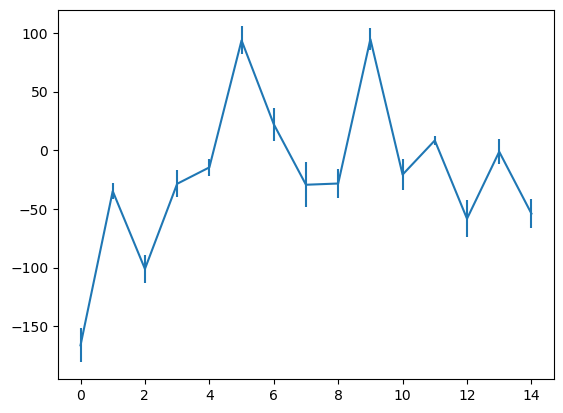

In [40]:
plt.errorbar(np.arange(len(imp['importances_mean'])), imp['importances_mean'], imp['importances_std'])

In [85]:
feature_names = clf.feature_names_in_
forest_importances = pd.Series(imp.importances_mean, index=feature_names)


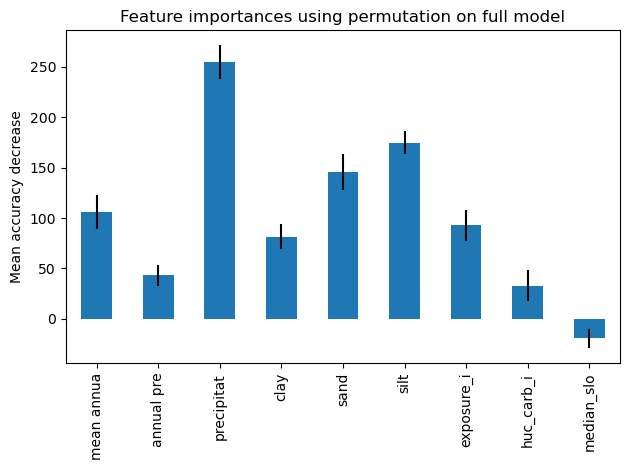

In [86]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=imp.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [87]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [90]:
clf = RandomForestRegressor(max_depth=15, random_state=0)
clf.fit(X_train, y_train) 

RandomForestRegressor(max_depth=15, random_state=0)

In [91]:
from sklearn.inspection import permutation_importance


def plot_permutation_importance(clf, X, y, ax):
    result = permutation_importance(clf, X, y, n_repeats=10, random_state=42, n_jobs=2)
    perm_sorted_idx = result.importances_mean.argsort()

    ax.boxplot(
        result.importances[perm_sorted_idx].T,
        vert=False,
        labels=X.columns[perm_sorted_idx],
    )
    ax.axvline(x=0, color="k", linestyle="--")
    return ax

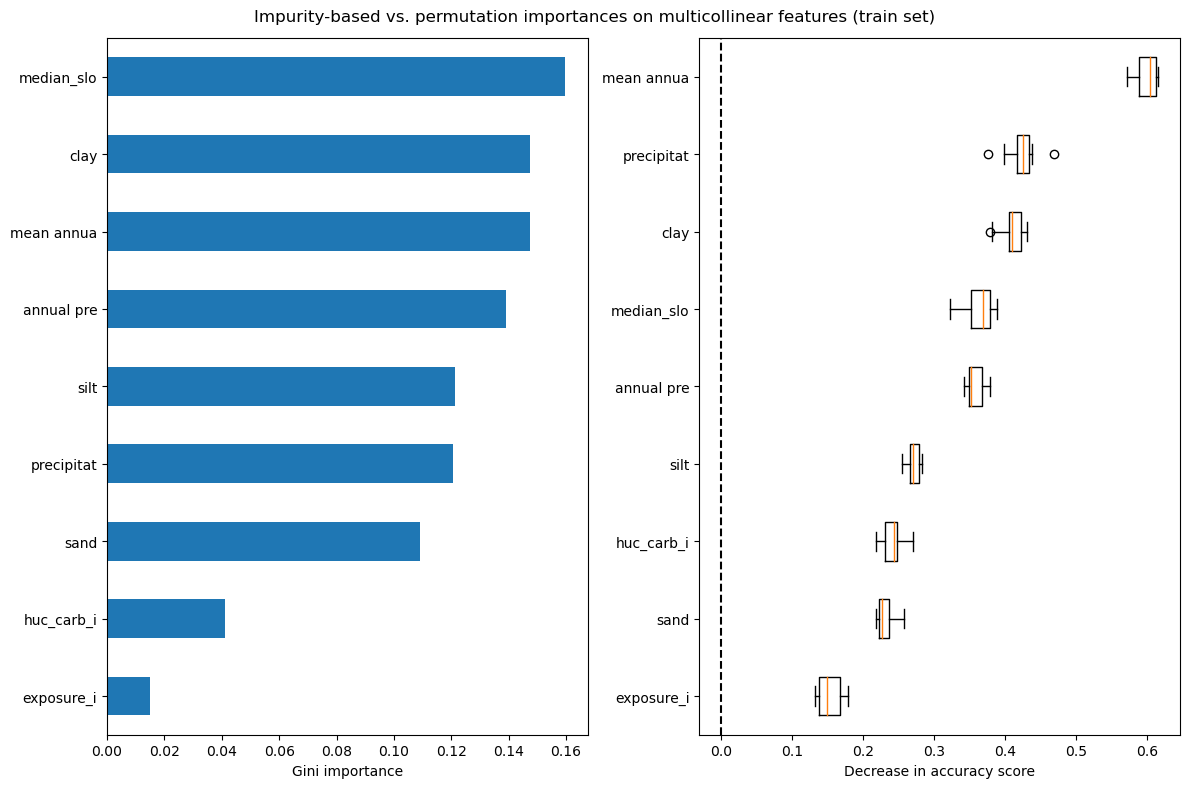

In [92]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

mdi_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
mdi_importances.sort_values().plot.barh(ax=ax1)
ax1.set_xlabel("Gini importance")
plot_permutation_importance(clf, X_train, y_train, ax2)
ax2.set_xlabel("Decrease in accuracy score")
fig.suptitle(
    "Impurity-based vs. permutation importances on multicollinear features (train set)"
)
_ = fig.tight_layout()

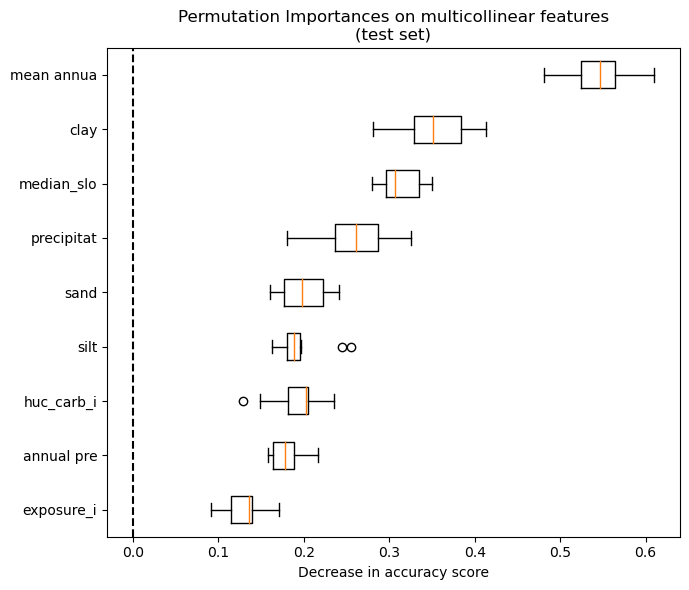

In [93]:
fig, ax = plt.subplots(figsize=(7, 6))
plot_permutation_importance(clf, X_test, y_test, ax)
ax.set_title("Permutation Importances on multicollinear features\n(test set)")
ax.set_xlabel("Decrease in accuracy score")
_ = ax.figure.tight_layout()

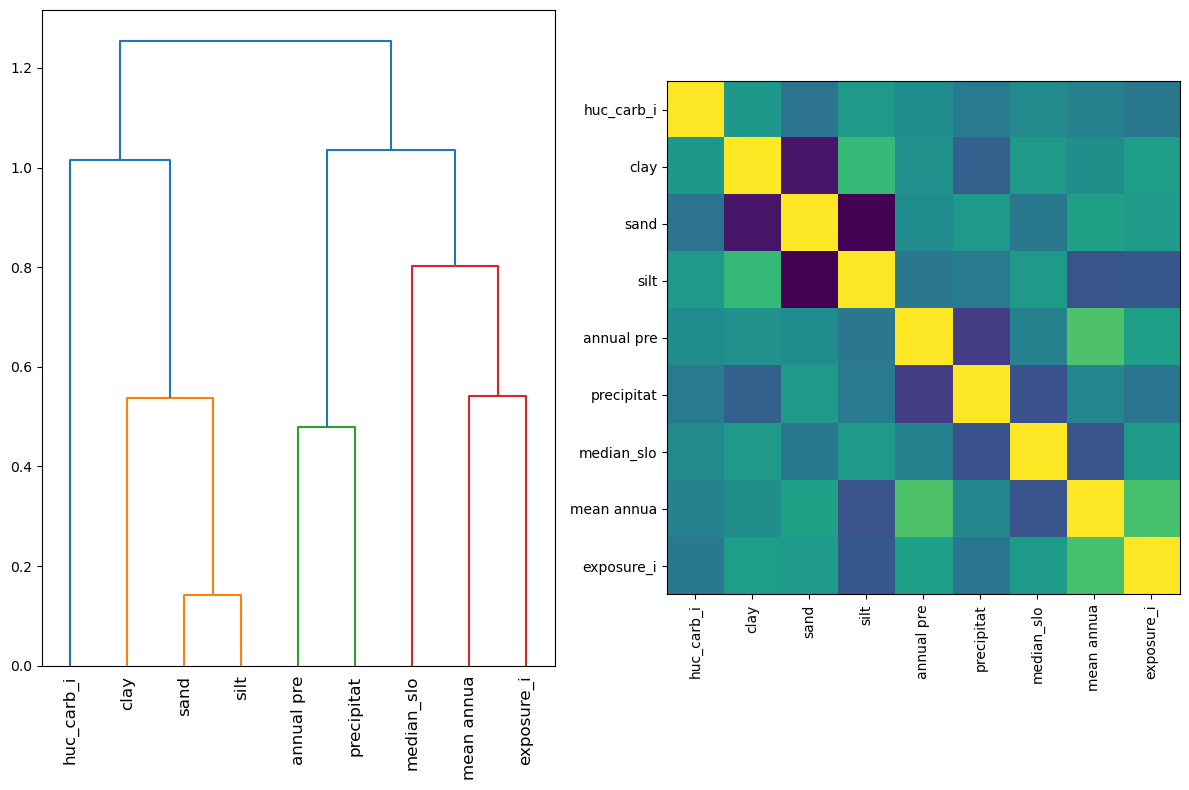

In [94]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X.columns.to_list(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
_ = fig.tight_layout()

In [95]:
from collections import defaultdict

cluster_ids = hierarchy.fcluster(dist_linkage, 0.4, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
selected_features_names = X.columns[selected_features]

X_train_sel = X_train[selected_features_names]
X_test_sel = X_test[selected_features_names]

clf_sel = RandomForestRegressor(n_estimators=100, random_state=42)
clf_sel.fit(X_train_sel, y_train)
print(
    "Baseline accuracy on test data with features removed:"
    f" {clf_sel.score(X_test_sel, y_test):.2}"
)

Baseline accuracy on test data with features removed: 0.43


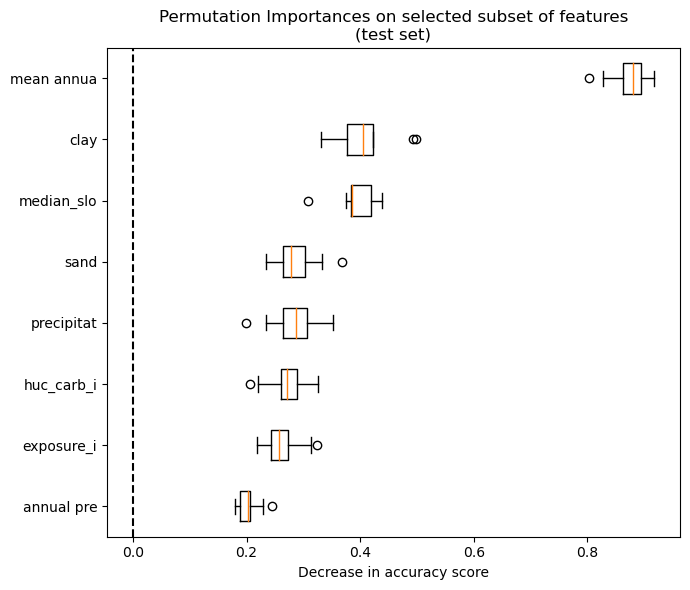

In [96]:
fig, ax = plt.subplots(figsize=(7, 6))
plot_permutation_importance(clf_sel, X_test_sel, y_test, ax)
ax.set_title("Permutation Importances on selected subset of features\n(test set)")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
plt.show()

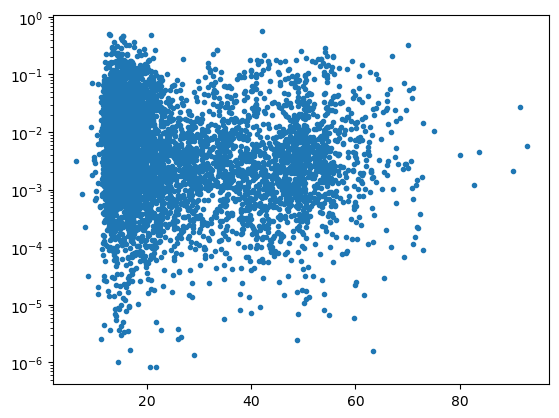

In [186]:
plt.semilogy(X['precipitat'], Y, '.')

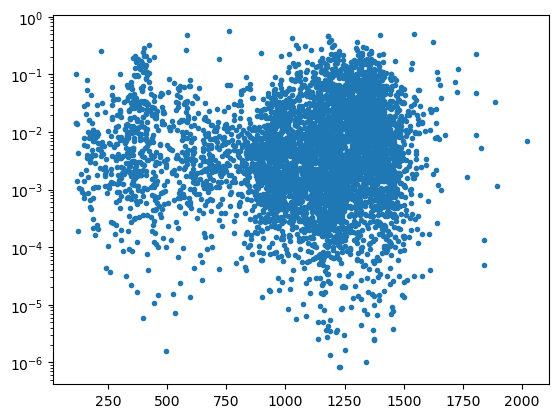

In [187]:
plt.semilogy(X['annual pre'], Y, '.')

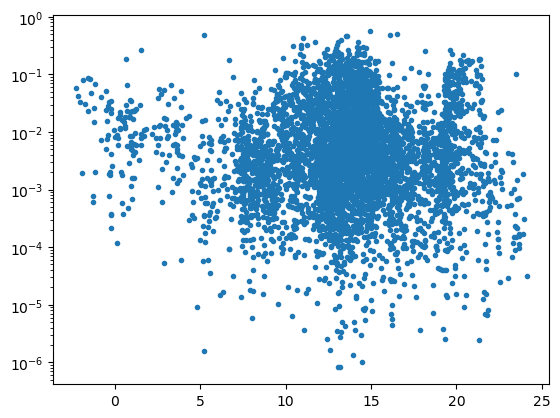

In [188]:
plt.semilogy(X['mean annua'], Y, '.')

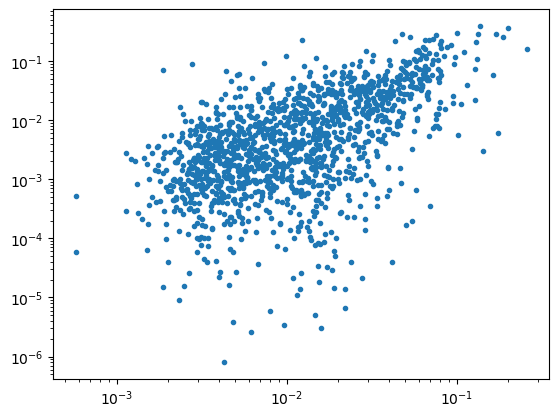

In [109]:
plt.loglog(clf.predict(X_test), y_test, '.')
#plt.xlim([0.4e-5,0.8])

In [200]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
poly.fit_transform(X_train_sel)

array([[1.00000000e+00, 1.00000000e+00, 1.37062500e+01, ...,
        1.37222105e+03, 3.75689755e+02, 1.02857183e+02],
       [1.00000000e+00, 5.00000000e-01, 1.36635135e+01, ...,
        6.67309456e+02, 4.43265089e+02, 2.94442013e+02],
       [1.00000000e+00, 5.00000000e-01, 1.38278802e+01, ...,
        7.27466642e+02, 2.78535167e+02, 1.06646593e+02],
       ...,
       [1.00000000e+00, 7.20113577e-01, 1.82390244e+01, ...,
        2.03774721e+03, 9.28650370e+02, 4.23208289e+02],
       [1.00000000e+00, 1.00000000e+00, 1.89535242e+01, ...,
        2.27610434e+03, 3.91708770e+02, 6.74115671e+01],
       [1.00000000e+00, 5.00000000e-01, 1.26644231e+01, ...,
        1.19124699e+03, 6.22430487e+02, 3.25221987e+02]])

In [213]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import numpy as np
model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('linear', LinearRegression(fit_intercept=False))])
# fit to an order-3 polynomial data
model = model.fit(X_train_sel, np.log10(y_train))
model.named_steps['linear'].coef_

array([-2.44268167e-01, -5.60209759e-01, -7.16070859e-02, -4.22448630e-01,
       -1.95075605e-03,  1.32869285e-01, -1.70250410e-02, -4.84309327e-01,
        9.69877471e-03,  9.72015390e-03,  9.84794799e-04,  1.93018354e-02,
       -1.08022672e-02, -2.06046298e-04,  5.03889870e-03,  2.18581097e-05,
       -1.49462255e-03,  6.31036744e-04,  2.19065312e-02,  1.31332837e-04,
       -9.98716662e-03,  3.73085218e-03,  5.93146318e-07, -3.40325709e-05,
       -2.78900811e-05,  4.69339007e-04, -1.01136102e-03,  1.10521712e-04])

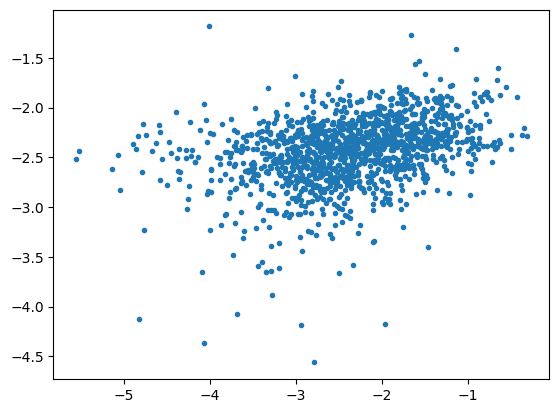

In [214]:
plt.plot(np.log10(y_test), model.predict(X_test_sel), '.')

## SHAP package

In [97]:
# Ran this on random forest regressor
import shap
X1000 = shap.utils.sample(X_train_sel,1000)

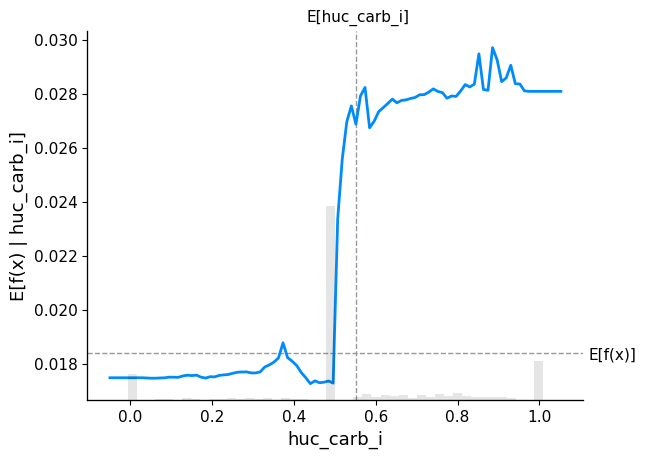

In [98]:
shap.partial_dependence_plot("huc_carb_i", clf_sel.predict,X1000, ice=False, model_expected_value=True, feature_expected_value=True)

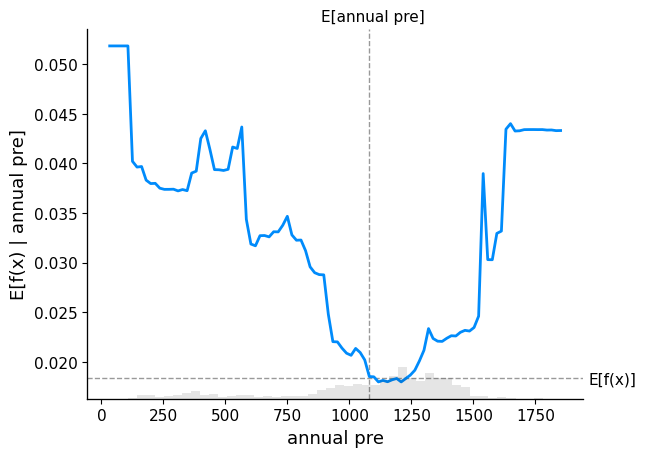

In [99]:
shap.partial_dependence_plot("annual pre", clf_sel.predict,X1000, ice=False, model_expected_value=True, feature_expected_value=True)

In [100]:
explainer = shap.Explainer(clf_sel.predict, X1000)
shap_values = explainer(X_test_sel)


ExactExplainer explainer: 1379it [02:15,  9.42it/s]                          


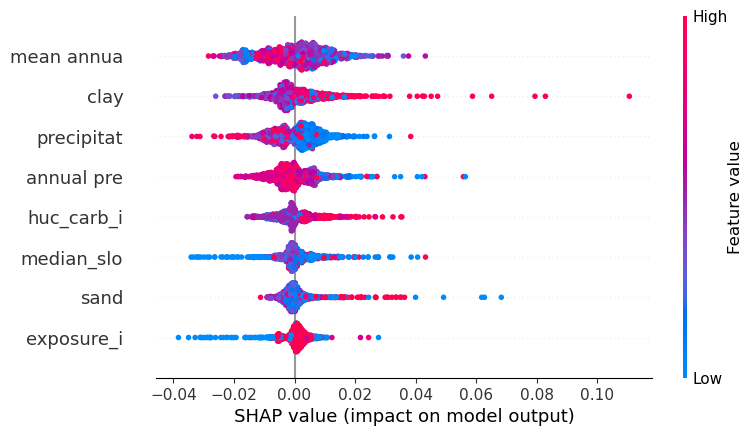

In [101]:
shap.plots.beeswarm(shap_values)

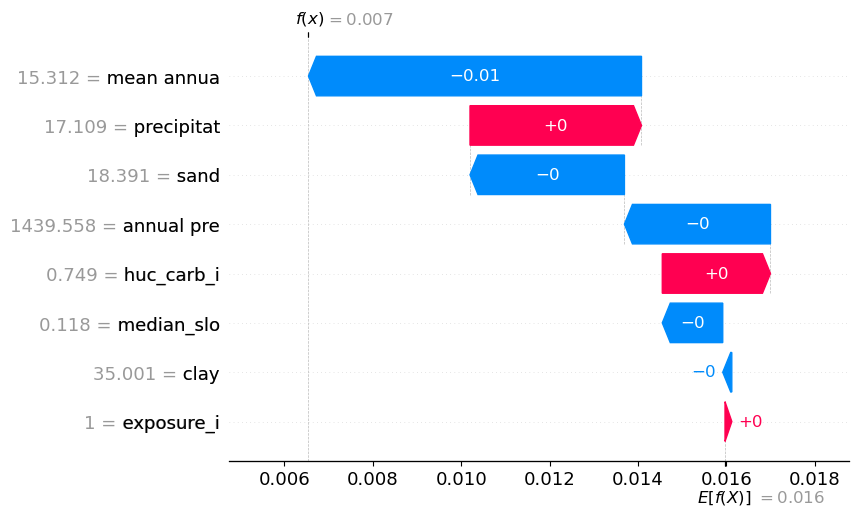

In [102]:
shap.plots.waterfall(shap_values[1])

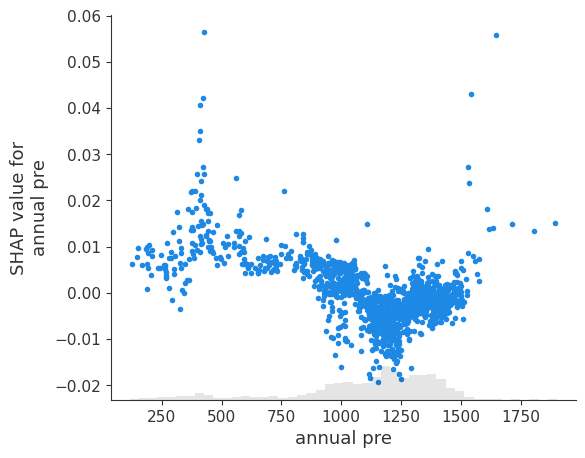

In [103]:
shap.plots.scatter(shap_values[:,"annual pre"])

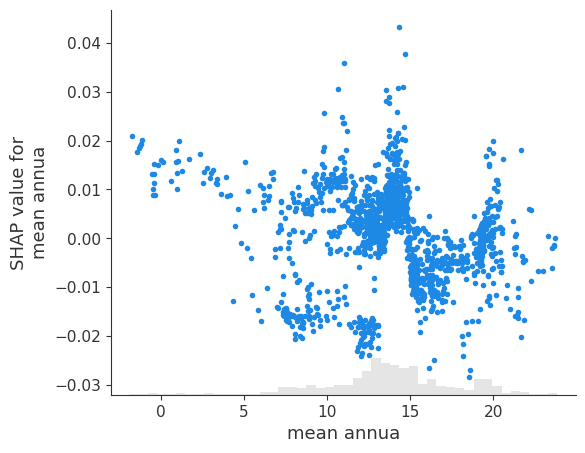

In [104]:
shap.plots.scatter(shap_values[:,"mean annua"])

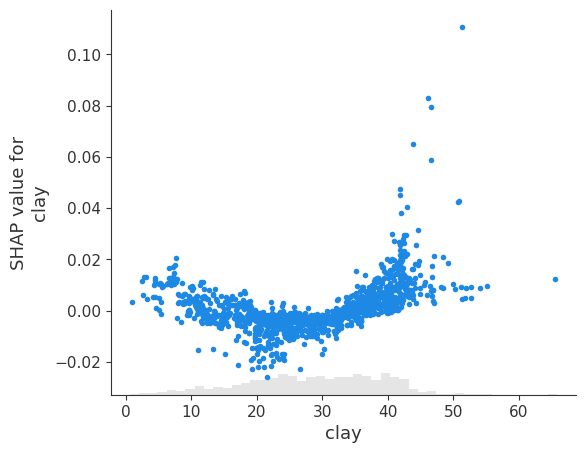

In [105]:
shap.plots.scatter(shap_values[:,"clay"])

No/low signal found from feature 0 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
No/low signal found from feature 1 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
No/low signal found from feature 2 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
No/low signal found from feature 3 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
No/low signal found from feature 4 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
No/low signal found from feature 5 (this is typically caused by constant or near-constant features)! Cluster distan

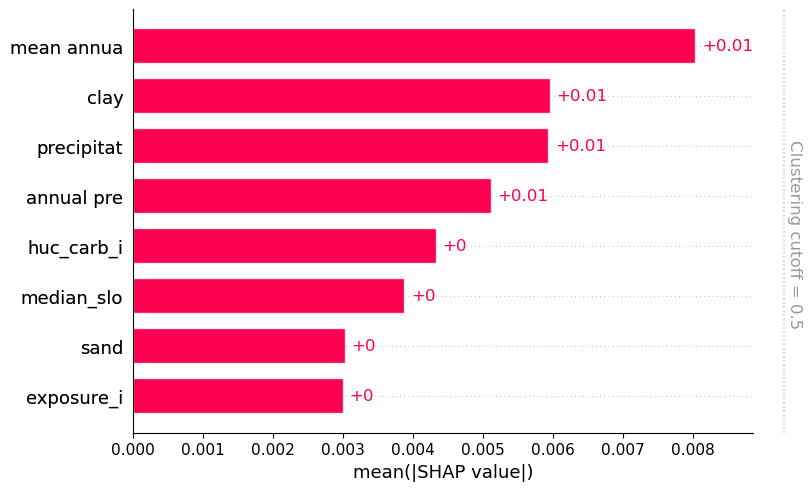

In [106]:
clustering = shap.utils.hclust(X_train_sel, y_train)
shap.plots.bar(shap_values, clustering=clustering)

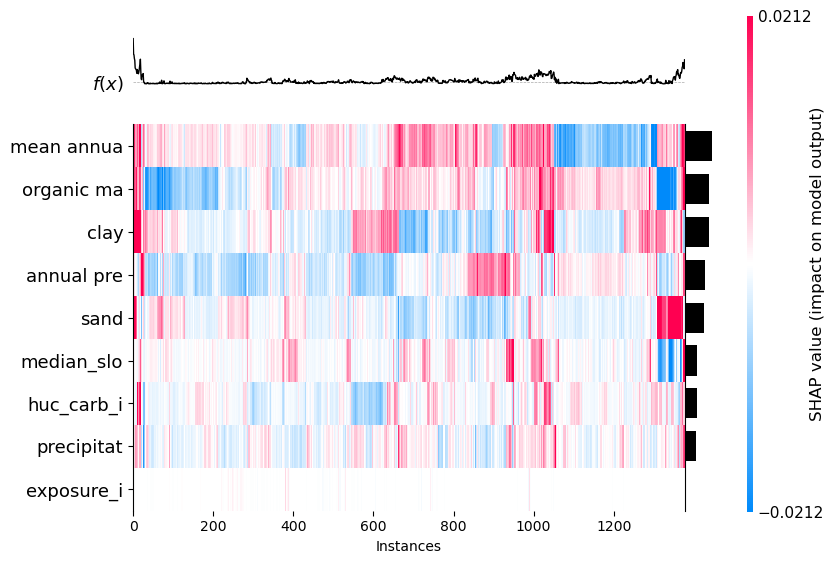

In [70]:
shap.plots.heatmap(shap_values)

## EconML

In [249]:
from econml.dr import SparseLinearDRLearner


In [253]:
X.keys()

Index(['huc_carb_i', 'mean annua', 'mean diurn', 'isothermal', 'annual pre',
       'precipitat', 'net primar', 'monthly me', 'cmi mean', 'carbonate',
       'clay', 'density', 'ksat', 'organic ma', 'ph', 'depth res',
       'rock fragm', 'sand', 'silt', 'depth', 'water stor'],
      dtype='object')

In [259]:
est = SparseLinearDRLearner()
est.fit(y_train, X_train["huc_carb_i"], X=X_train[['precipitat', 
       'clay', 'organic ma', 'ph', 'depth res',
       'rock fragm', 'sand', 'silt',]])

/home/mcoving/anaconda3/envs/geo_env/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


/home/mcoving/anaconda3/envs/geo_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mcoving/anaconda3/envs/geo_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

KeyboardInterrupt: 

In [258]:
X_train[['precipitat',  'clay', 'organic ma', 'ph', 'depth res',
       'rock fragm', 'sand', 'silt']]

precipitat       clay  organic ma        ph   depth res  rock fragm  \
16570   14.017857  37.043502   10.141853  5.288222  100.487980    0.054251   
25510   21.472973  25.832334   17.159313  6.261146   66.946595    0.007582   
6352    16.382949  26.971590   10.326984  5.186569   88.915708    0.027608   
6706    13.744848  42.284292    8.058348  6.023581   81.554812    0.096532   
25324   13.987218  37.917264   11.069752  5.801315   78.546202    0.048289   
...           ...        ...         ...       ...         ...         ...   
15472   37.429070  13.530535    2.828249  7.855194   48.225818    0.316794   
18444   16.078431  25.863344   13.070834  5.492273  107.248297    0.099776   
27764   33.699593  45.141413   20.572027  7.926697   67.512066    0.211503   
28274   34.611454  47.708535    8.210455  7.206428   48.135579    0.417997   
4041    48.054808  34.514446   18.033912  6.811458   50.275871    0.025507   

            sand       silt  
16570  16.889645  46.066854  
25510   9.009003  65.158664  
6352   19.978586  53.049824  
6706   17.833684  39.882024  
25324  15.242272  46.840464  
...          ...        ...  
15472  65.955179  20.514286  
18444  26.540065  47.596590  
27764  20.123530  34.735057  
28274  22.424476  29.869344  
4041   13.110802  52.375410  

[4013 rows x 8 columns]

### Support Vector Regression

In [107]:
from sklearn import svm
regr = svm.SVR()
regr.fit(X_train, np.log10(y_train))

SVR()

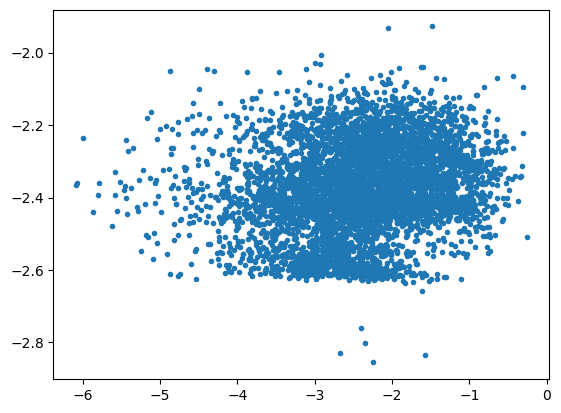

In [108]:
plt.plot(np.log10(Y), regr.predict(X), '.')